In [8]:
# -------------------------------------------------- #
# Author: Jiayu Yang
# Date: 15 May 2023
# File Name: [Project CD] 2D FEM with Galerkin & Petrov-Galerkin Scheme
# File Description: 
#    This file aims at solving the 2D steady convection-diffusion problems using the
#    Finite Element Method (FEM) with respectively:
#        - Galerkin Approximation Scheme
#        - Petrov-Galerkin Approximation Scheme
#    The comparison of stability is also included.
# Web Link to Github: https://github.com/LakeYang0818/Solving-Convection-Diffusion-Problems
# -------------------------------------------------- #

In [ ]:
import numpy as np
import math as m
import mpmath
import matplotlib.pyplot as plt
import sys
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator

colorinterpolation = 50
colourMap = plt.cm.jet

In [9]:
def FEM_2D_Galerkin(a, mu, s, u0, uN, N, M):
    xmesh = np.zeros(N)  # Mesh size (Delta_x)
    xmesh = list(i / N for i in range(N + 1)) # Mesh point
    ymesh = np.zeros(M)  # Mesh size (Delta_y)
    ymesh = list(i / M for i in range(M + 1)) # Mesh point
    dx = 1 / N
    dy = 1 / M
    
    # Basis Functions
    def xphi(k: int):
        x_i = xmesh[k]
        x_l = xmesh[k - 1] if k != 0 else x_i
        x_r = xmesh[k + 1] if k != N else x_i
        step = lambda x: np.heaviside(x - x_l, 1) - np.heaviside(x - x_r, 0)
        return lambda x: step(x) * (1 - np.abs(x - x_i) / dx)

    def yphi(k: int):
        y_i = xmesh[k]
        y_l = xmesh[k - 1] if k != 0 else y_i
        y_r = xmesh[k + 1] if k != M else y_i
        step = lambda y: np.heaviside(y - y_l, 1) - np.heaviside(y - y_r, 0)
        return lambda y: step(y) * (1 - np.abs(y - y_i) / dy)

    X_left  = + a / (2 * dx) - mu / (dx ** 2)
    X_right = - a / (2 * dx) - mu / (dx ** 2)
    Y_left  = + a / (2 * dy) - mu / (dy ** 2)
    Y_right = - a / (2 * dy) - mu / (dy ** 2)
    XY_mid  = - (X_left + X_right + Y_left + Y_right)
    
    
    # Source Vector S
    S = np.ones(((M - 1) * (N - 1), (M - 1) * (N - 1))) * s
    S_left, S_mid, S_right  = 1 / 6, 4 / 6, 1 / 6
    for i in range(N + 1):
        if i == 0:   
            S[i,   i  ] = S_mid
            S[i, i + 1] = S_left   
        elif i == N:
            S[i, i - 1] = S_right
            S[i,   i  ] = S_mid
        else:
            S[i, i - 1] = S_right
            S[i,   i  ] = S_mid
            S[i, i + 1] = S_left
    S = np.array(list(sum(S[n, ]) for n in range(len(S))))
    
    # Global Stiffness Matrix A
    A = np.zeros(((M - 1) * (N - 1), (M - 1) * (N - 1)))
    
    A_right = np.zeros((N - 1, N - 1))
    A_left  = np.zeros((N - 1, N - 1))

    for i in range(N - 1):
        A_right[i, i] = X_right
        A_left[i,  i] = X_left

    for i in range(N - 1):
        num_min = i * (N - 1)
        num_max = (i + 1) * (N - 1)
        if i == 0:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = A_right
        elif i == N - 2:
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = A_left
        else:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = A_right
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = A_left

    for i in range(N - 1):
        num_min = i * (N - 1)
        num_max = (i + 1) * (N - 1)

        # Left and Right Matrices
        if i == 0:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = A_left
        elif i == N - 2:
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = A_right
        else:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = A_left
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = A_right

        # Diagonal Matrices
        A_diag = np.zeros((M - 1, M - 1))        
        for j in range(M - 1):
            if j == 0:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = Y_left

            elif j == M - 2:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j - 1] = Y_right
            else:
                A_diag[j, j - 1] = Y_right
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = Y_left

        A[num_min : num_max, num_min : num_max] = A_diag
        
    FEM_2D_Galerkin = np.zeros((N + 1, M + 1))
    FEM_2D_Galerkin[1 : N, 1 : M] = np.linalg.solve(A, S).reshape((N - 1, M - 1))
    
    FEM_2D_Galerkin_sol = np.zeros((M + 1, N + 1))

    for i in range(N + 1):
        for j in range(M + 1):
            FEM_2D_Galerkin_sol[i, j] = xphi(i)(xmesh[i]) * yphi(j)(ymesh[j]) * FEM_2D_Galerkin[i, j]

    return FEM_2D_Galerkin_sol

In [12]:
def FEM_2D_Petrov_Galerkin(a, mu, s, u0, uN, N, M):
    
    Pe = a / (2 * mu * N)
    beta = mpmath.coth(Pe) - 1 / Pe
    tau = beta / (2 * abs(a) * N)
    xmesh = np.zeros(N)  # Mesh size (Delta_x)
    xmesh = list(i / N for i in range(N + 1)) # Mesh point
    ymesh = np.zeros(M)  # Mesh size (Delta_x)
    ymesh = list(i / M for i in range(M + 1)) # Mesh point
    
    dx = 1/N
    dy = 1/M
    
    # Basis Functions
    def xphi(k: int):
        x_i = xmesh[k]
        x_l = xmesh[k - 1] if k != 0 else x_i
        x_r = xmesh[k + 1] if k != N else x_i
        step = lambda x: np.heaviside(x - x_l, 1) - np.heaviside(x - x_r, 0)
        return lambda x: step(x) * (1 - np.abs(x - x_i) / dx)

    def yphi(k: int):
        y_i = xmesh[k]
        y_l = xmesh[k - 1] if k != 0 else y_i
        y_r = xmesh[k + 1] if k != M else y_i
        step = lambda y: np.heaviside(y - y_l, 1) - np.heaviside(y - y_r, 0)
        return lambda y: step(y) * (1 - np.abs(y - y_i) / dy)
    
    
    X_left  = + a / 2 - mu / dx - tau * (a ** 2) / dx
    X_right = - a / 2 - mu / dx - tau * (a ** 2) / dx
    Y_left  = + a / 2 - mu / dy - tau * (a ** 2) / dy
    Y_right = - a / 2 - mu / dy - tau * (a ** 2) / dy
    XY_mid  = - (X_left + X_right + Y_left + Y_right)
    
    # print(X_left, X_right, Y_left, Y_right, XY_mid)
    
    # Source Vector S
    S = np.ones(((M - 1) * (N - 1), (M - 1) * (N - 1))) * s
    
    S_left  = 1 / 6
    S_mid   = 4 / 6
    S_right = 1 / 6
    
    for i in range(N + 1):
        if i == 0:   
            S[i,   i  ] = S_mid
            S[i, i + 1] = S_left   
        
        elif i == N:
            S[i, i - 1] = S_right
            S[i,   i  ] = S_mid
            
        else:
            S[i, i - 1] = S_right
            S[i,   i  ] = S_mid
            S[i, i + 1] = S_left
    
    S = np.array(list(sum(S[n, ]) for n in range(len(S))))
    
    A = np.zeros(((M - 1) * (N - 1), (M - 1) * (N - 1)))
    
    A_right = np.zeros((N - 1, N - 1))
    A_left  = np.zeros((N - 1, N - 1))

    for i in range(N - 1):
        A_right[i, i] = X_right
        A_left[i,  i] = X_left

    for i in range(N - 1):
        num_min = i * (N - 1)
        num_max = (i + 1) * (N - 1)
        if i == 0:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = A_right
        elif i == N - 2:
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = A_left
        else:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = A_right
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = A_left

    for i in range(N - 1):
        num_min = i * (N - 1)
        num_max = (i + 1) * (N - 1)

        # Left and Right Matrices
        if i == 0:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = A_left
        elif i == N - 2:
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = A_right
        else:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = A_left
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = A_right

        # Diagonal Matrices
        A_diag = np.zeros((M - 1, M - 1))        
        for j in range(M - 1):
            if j == 0:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = Y_left

            elif j == M - 2:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j - 1] = Y_right
            else:
                A_diag[j, j - 1] = Y_right
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = Y_left

        A[num_min : num_max, num_min : num_max] = A_diag
        
    FEM_2D_Petrov_Galerkin = np.zeros((N + 1, M + 1))
    FEM_2D_Petrov_Galerkin[1 : N, 1 : M] = np.linalg.solve(A, S).reshape((N - 1, M - 1))

    FEM_2D_Petrov_Galerkin_sol = np.zeros((N + 1, M + 1))
    for i in range(N + 1):
        for j in range(M + 1):
            FEM_2D_Petrov_Galerkin_sol[i, j] = xphi(i)(xmesh[i]) * yphi(j)(ymesh[j]) * FEM_2D_Petrov_Galerkin[i, j]
            
    return FEM_2D_Petrov_Galerkin_sol
            

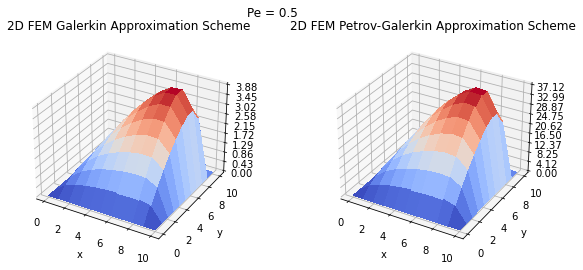

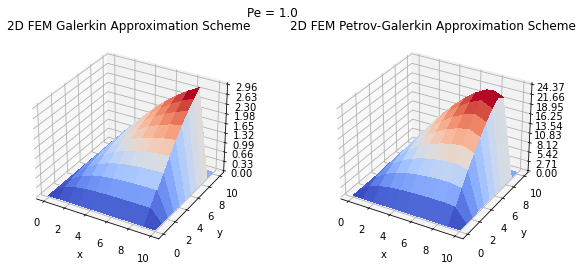

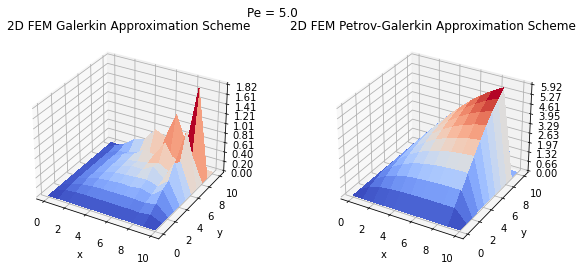

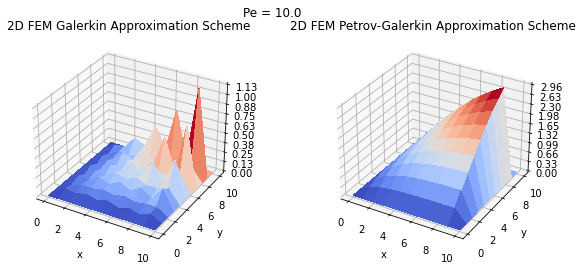

In [17]:
def Plot_3D_comparison(a, mu, s, u0, uN, N, M):
    Pe = a / (2 * N * mu)
    
    # Calculation
    FEM_ga = FEM_2D_Galerkin(a, mu, s, u0, uN, N, M)
    FEM_pg = FEM_2D_Petrov_Galerkin(a, mu, s, u0, uN, N, M)
    
    FEM_ga_data = FEM_ga.reshape((N + 1, M + 1))
    FEM_pg_data = FEM_pg.reshape((N + 1, M + 1))
    
    # Plot 
    fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 4))
    fig.suptitle('Pe = %s'%Pe)
    x = range(N + 1)
    y = range(M + 1)
    X, Y = np.meshgrid(x, y)
    
    C1 = axs[0].plot_surface(X, Y, FEM_ga_data, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    
    C2 = axs[1].plot_surface(X, Y, FEM_pg_data, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    
    axs[0].zaxis.set_major_locator(LinearLocator(10))
    axs[0].zaxis.set_major_formatter('{x:.02f}')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    
    axs[1].zaxis.set_major_locator(LinearLocator(10))
    axs[1].zaxis.set_major_formatter('{x:.02f}')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    
    axs[0].set_title('2D FEM Galerkin Approximation Scheme')
    axs[1].set_title('2D FEM Petrov-Galerkin Approximation Scheme')
    
    #plt.savefig('/Users/pc/Desktop/[P2] Convection-Diffusion Problem/Images Pool/2D Comparison of FEM with different schemes at Pe = %s.png'%Pe)
    plt.show()
    
N = 10
M = 10
s = 1
mu = 1
u0 = 0
uN = 0
Pe_choice = [0.5, 1, 5, 10]
for Pe in Pe_choice:
    a = Pe * 2 * N * mu
    Plot_3D_comparison(a, mu, s, u0, uN, N, M)
    
    
    

In [ ]:
# --------------FEM 2D Galerkin Scheme------------------
print(FEM_2D_Galerkin.shape, len(xmesh))
# 2D Plane Contour Plot
colorinterpolation = 50
colourMap = plt.cm.jet
plt.contourf(xmesh, ymesh, np.transpose(FEM_2D_Galerkin), colorinterpolation, cmap=colourMap)
plt.colorbar()
plt.show()

"""
# 3dim bw Plot
plot2D(xmesh, ymesh, np.transpose(FEM_2D_Galerkin))
pyplot.show()
"""

# 3dim color DM Plot
x = range(N + 1)
y = range(M + 1)
FEM_2D_Galerkin_Data = FEM_2D_Galerkin.reshape((N + 1, M + 1))
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, y)
ha.plot_surface(X, Y, FEM_2D_Galerkin_Data)
plt.show()


# --------------FEM 2D Petrov Galerkin Scheme------------------

# 2D Plane Contour Plot
colorinterpolation = 50
colourMap = plt.cm.jet
plt.contourf(xmesh, ymesh, np.transpose(FEM_2D_Petrov_Galerkin), colorinterpolation, cmap=colourMap)
plt.colorbar()
plt.show()

# 3dim color DM Plot
x = range(N + 1)
y = range(N + 1)
FEM_2D_Petrov_Galerkin_Data = FEM_2D_Petrov_Galerkin.reshape((N + 1, M + 1))
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, y)
ha.plot_surface(X, Y, FEM_2D_Petrov_Galerkin_Data)
plt.show()